In [65]:
!pip install colorama
!pip install flax

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [66]:
import time
import numpy as np
import matplotlib.pyplot as plt
from flax.training import checkpoints
from flax import linen as nn  

from Azul_Simulator import *

In [67]:
def pack_statedict(state, d, opp=False):
    
    if opp:
        si_row = State_Indices.ROWS_OPP.value
        si_boa = State_Indices.BOARD_OPP.value
        si_flo = State_Indices.FLOOR_OPP.value
    else:
        si_row = State_Indices.ROWS.value
        si_boa = State_Indices.BOARD.value
        si_flo = State_Indices.FLOOR.value
        
    for i in range(5):
        
        idx_pl = None
        max_pl = 0
        
        for j in range(5):
            
            n = state[si_row[i] + j]
            
            if n > max_pl:
                
                idx_pl = j
                max_pl = n
                
            d['board_hl'][i][j] = (state[si_boa + (5 * i) + j] == 1)
        
        d['pat_lines'].append((idx_pl, max_pl))
    
    if state[si_flo + Tile_Offsets.S.value] == 1:
        d['floor'].append(-2)
        
    for i in range(5):
        n = state[si_flo + i]
        if n != 0:
            d['floor'] += [i] * n

def process_state(state):
    
    pla_dict = dict()
    opp_dict = dict()
    
    for d in (pla_dict, opp_dict):
        
        d['pat_lines'] = []
        d['board_hl'] = [[-1]*5 for _ in range(5)]
        d['floor'] = []
    
    si_cen = State_Indices.CENTER.value
    si_fac = State_Indices.FACTORIES.value
    
    letters = dict()
    highlights = dict()
    
    colors = [Fore.BLUE, Fore.YELLOW, Fore.RED, Fore.BLACK, Fore.WHITE, Fore.BLACK]
    colors_h = [Back.BLUE, Back.YELLOW, Back.RED, Back.BLACK, Back.WHITE, Back.BLACK]
    counter = 0
    
    for data in Tile_Offsets:
        
        letters[data.value] = colors[counter] + data.name + Fore.RESET
        highlights[data.value] = colors_h[counter] + data.name + Back.RESET
        counter += 1
        
    # Center
    center = []
    
    if state[si_cen + Tile_Offsets.S.value] == 1:
        center.append(-2)
        
    for i in range(5):
        n = state[si_cen + i]
        if n != 0:
            center += [i] * n
    
    # Factories
    factories = [[] for _ in range(5)]
    
    for i in range(5):
        for j in range(5):
            n = state[si_fac[i] + j]
            factories[i] += [j] * n
            
    for i in range(len(factories)):
        if len(factories[i]) < 4:
            factories[i] += [-1]*(4 - len(factories[i]))
            
    pack_statedict(state, pla_dict)
    pack_statedict(state, opp_dict, True)
        
    return letters, highlights, center, factories, pla_dict, opp_dict

In [68]:
colors = ['dodgerblue', 'gold', 'red', 'black', 'white', 'lightcyan', 'antiquewhite']

def plot_state(state, comp='pco'):
    
    comp = set(comp)
    assert not (comp - {'p', 'c', 'o'})
    
    l, h, cen, fac, pd, od = process_state(state)
    
    fig, ax = plt.subplots()
    
    xmax = 12.0
    ymax = 7.5*('p' in comp) + 7.5*('o' in comp) + 6*('c' in comp)
    
    ax.set_xlim(0, xmax)
    ax.set_ylim(0, ymax)
    
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    
    if 'p' in comp:
        
        plt.text(1./3., ymax - 2./3., 'Computer')
        plt.text(1./3., ymax - 1.0, f'Score: {state[State_Indices.SCORE.value]}')
        rect = plt.Rectangle((0.25, ymax - 7.25), width=11.5, height=7.0,
                facecolor='cornsilk', edgecolor='black')
        ax.add_patch(rect)
        plot_board(ax, pd['pat_lines'], pd['board_hl'], pd['floor'], ymax - 1.5)
        
    if 'c' in comp:
        
        if 'o' in comp:
            yoff = 12.0
        else:
            yoff = 4.5
         
        # Factories
        plt.text(2.5625, yoff + 1.0, 'Factories')
        rect = plt.Rectangle((0.25, yoff - 4.5), width=5.25, height=6.0,
                facecolor='cornsilk', edgecolor='black')
        ax.add_patch(rect)
        
        for i in range(5):
            
            plt.text(0.6875, yoff - i + 0.25, str(i + 1))
            
            for j in range(4):
                
                c = fac[i][j]
                square = plt.Rectangle((1.3125 + j, yoff - i), width=0.75, height=0.75,
                        facecolor=colors[c], edgecolor='black')
                ax.add_patch(square)
        
        # Center
        plt.text(8.285, yoff + 1.0, 'Center')
        rect = plt.Rectangle((5.75, yoff - 4.5), width=6.0, height=6.0,
                facecolor='cornsilk', edgecolor='black')
        ax.add_patch(rect)
        
        for i in range(len(cen)):
            
            c = cen[i]
            j = i // 5
            k = i % 5
            square = plt.Rectangle((6.375 + k, yoff - j), width=0.75, height=0.75,
                        facecolor=colors[c], edgecolor='black')
            ax.add_patch(square)
        
    if 'o' in comp:
        
        plt.text(1./3., 7.5 - 2./3., 'Player')
        plt.text(1./3., 7.5 - 1.0, f'Score: {state[State_Indices.SCORE_OPP.value]}')
        rect = plt.Rectangle((0.25, 0.25), width=11.5, height=7.0,
                facecolor='cornsilk', edgecolor='black')
        ax.add_patch(rect)
        plot_board(ax, od['pat_lines'], od['board_hl'], od['floor'], 6)
    
    fig.set_size_inches((8, 8*ymax/xmax))
    
def plot_board(ax, pl, bh, fl, yoff):
    
    # Pattern lines
    for i in range(5):
        for j in range(i+1):
            c, n = pl[i]
            if j < (i + 1 - n):
                c = -1
            square = plt.Rectangle((4.5 - j, yoff - i), width=0.75, height=0.75,
                    facecolor=colors[c], edgecolor='black')
            ax.add_patch(square)
            
    # Wall tiles
    for i in range(5):
        for j in range(5):
            edgecolor = 'black' if not bh[i][j] else 'lime'
            square = plt.Rectangle((6 + i, yoff - 4 + j), width=0.75, height=0.75,
                    facecolor=colors[Board[4 - i][j]], edgecolor=edgecolor)
            ax.add_patch(square)
            
    # Floor tiles
    for i in range(11):
        if i < len(fl):
            c = fl[i]
        else:
            c = -1
        square = plt.Rectangle((i + 0.5, yoff - 5.5), width=0.75, height=0.75,
                    facecolor=colors[c], edgecolor='black')
        ax.add_patch(square)

In [69]:
from jax import jit

class TTTModel(nn.Module):
  """A simple MLP model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Dense(features=64)(x)
    body = nn.Dense(features=32)(x)
    x = nn.Dense(features=181)(body)
    value = nn.tanh(nn.Dense(features=1)(body)) #Value estimate between -1 and 1
    return x, value

@jit
def model_agent(x, params):
  logits, value = TTTModel().apply(params, x)
  return nn.softmax(logits), value

In [70]:
def learned_agent(board, state):
    prior = model_agent(board, {'params': state['params']})[0] + 1e-10
    prior *= get_valid_mask(board)
    return np.argmax(prior)

CKPT_DIR = "ckpts"
state = checkpoints.restore_checkpoint(ckpt_dir=CKPT_DIR, target=None)

Welcome to the Azul simulator!



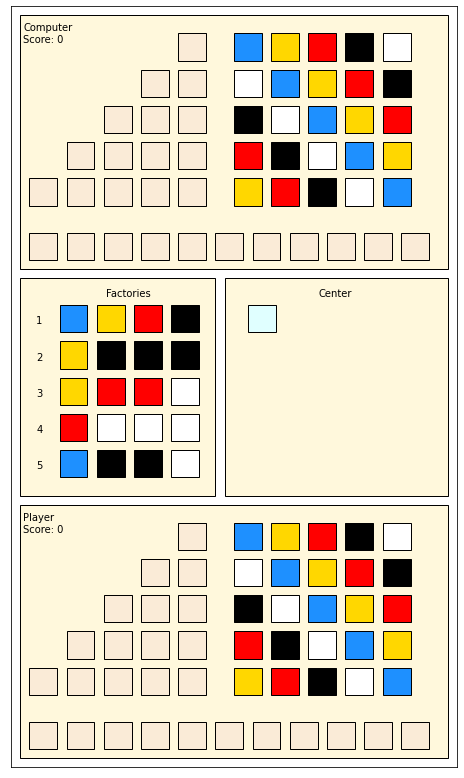

Player's turn...
Enter a move: 
4WF


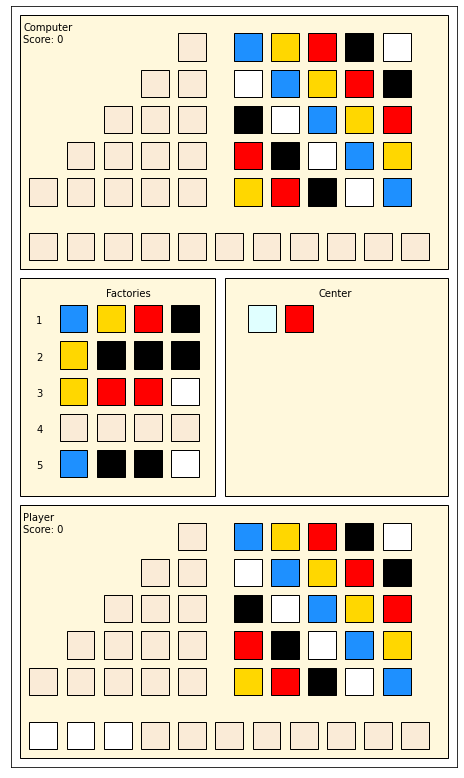

Computer's turn...


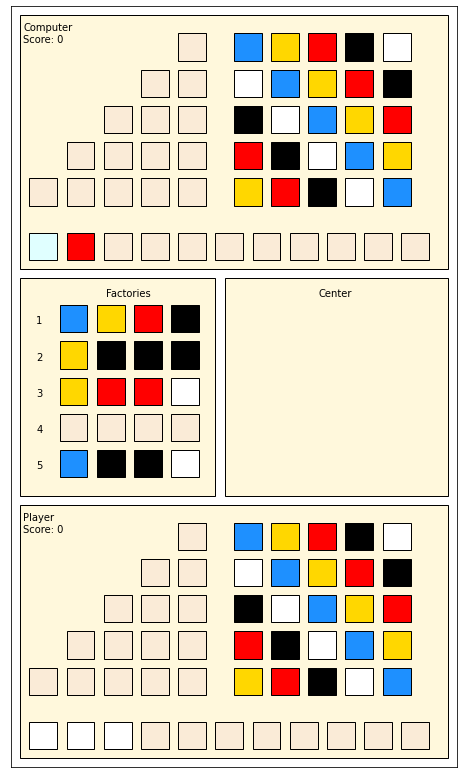

Player's turn...
Enter a move: 
3W6
Invalid input string, pease try again.
Enter a different move: 
3W6
Invalid input string, pease try again.
Enter a different move: 
3W4


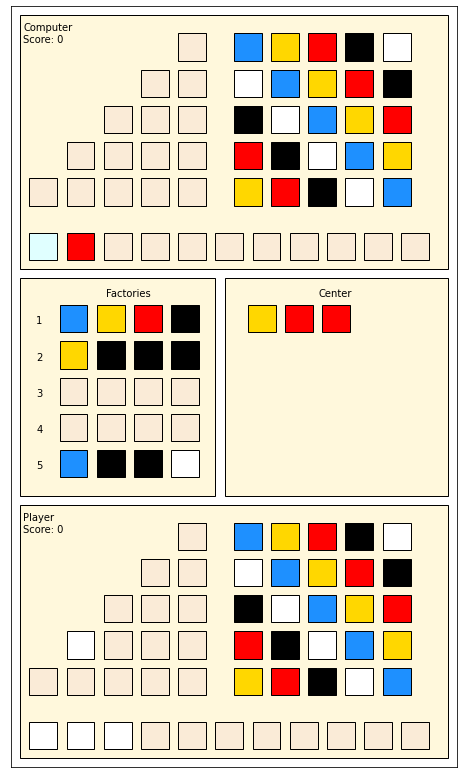

Computer's turn...


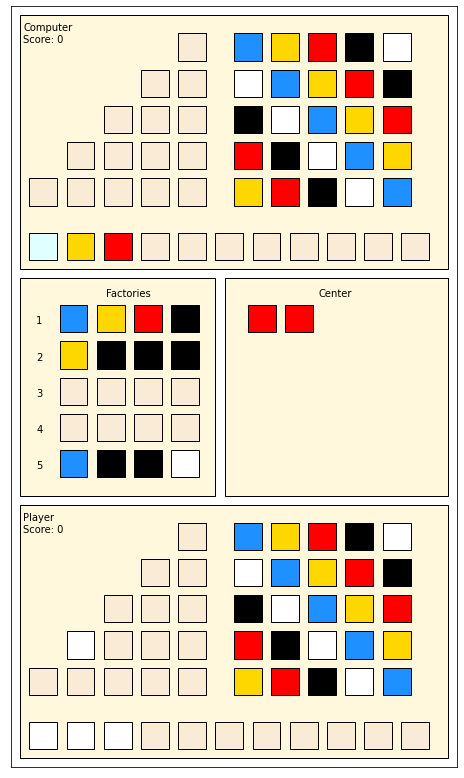

Player's turn...
Enter a move: 
CR2


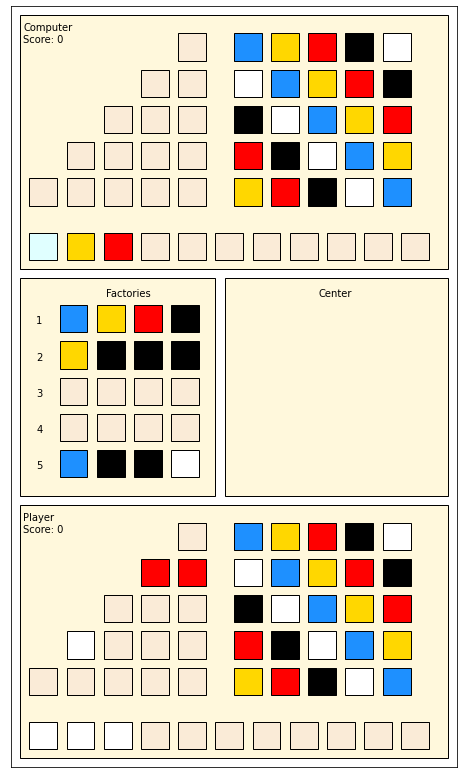

Computer's turn...


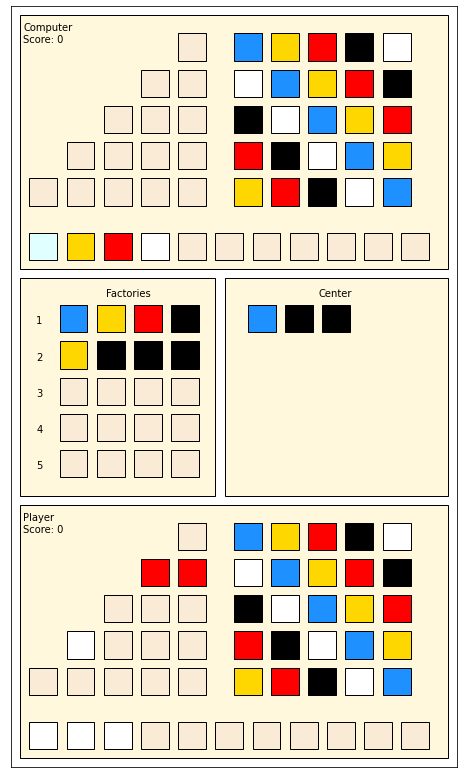

Player's turn...
Enter a move: 


KeyboardInterrupt: ignored

In [71]:
print("Welcome to the Azul simulator!")
print()

computer_turn = True
end = False
first_turn = True
board = init_board()
rng = np.random.default_rng(6546547)

while not end:
    if computer_turn:
        if not first_turn:
          print("Computer's turn...")
    else:
        print("Player's turn...")
        print("Enter a move: ")
    
    # Flip the state to put all player data in the current player section
    if not computer_turn:
        board = flip_board(board)
        invalid_action_or_input = True

        while invalid_action_or_input:
            input_string = input()
            board, error = take_action_from_string(board, input_string, rng)

            # Validate input_string
            if error:
                print("Enter a different move: ")
                continue
            invalid_action_or_input = False
        board = flip_board(board)
    else:
        action = learned_agent(board, state)
        board = get_next_state(board, action, rng)

    reward, end = get_reward(board)
    if end and reward == -1:
        print()
        print("Computer wins!!!")
        break
    elif end and reward == 1:
        print()
        print("Player wins!!!")
        break

    plot_state(board)
    plt.show()
    first_turn = False

    if board[Action_Indices.NOOP.value] == 1:
        board = get_next_state(board, Action_Indices.NOOP.value, rng)
    else:
        computer_turn = not computer_turn